In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test_dataset.csv to test_dataset.csv
Saving train_dataset.csv to train_dataset.csv


In [ ]:
# 1_load_inspect.py
import pandas as pd

train_df = pd.read_csv("train_dataset.csv")
test_df = pd.read_csv("test_dataset.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Train columns:", train_df.columns.tolist())
print("Test columns:", test_df.columns.tolist())

# Check label existence
has_test_labels = "smoking" in test_df.columns
print("Test has 'smoking' column?:", has_test_labels)

# Show class distribution in train
print("Train smoking value counts:")
print(train_df["smoking"].value_counts(dropna=False))


Train shape: (38984, 23)
Test shape: (16708, 22)
Train columns: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking']
Test columns: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']
Test has 'smoking' column?: False
Train smoking value counts:
smoking
0    24666
1    14318
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv("train_dataset.csv")

X = train.drop(columns=["smoking"])
y = train["smoking"]


In [ ]:
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

categorical_cols = [col for col in X.columns
                    if X[col].nunique() <= 10 and col not in numeric_cols]

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries']
Categorical: []


In [ ]:
def cap_outliers(df, cols):
    df = df.copy()
    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[col] = df[col].clip(lower, upper)
    return df


In [ ]:
X_capped = X.copy()
X_capped[numeric_cols] = cap_outliers(X, numeric_cols)


In [ ]:
from sklearn.model_selection import train_test_split

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_capped, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)
log_reg_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=2000))
])


In [ ]:
log_reg_pipe.fit(X_train_raw, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'height(cm)',
                                                   'weight(kg)', 'waist(cm)',
                                                   'eyesight(left)',
                                                   'eyesight(right)',
                                                   'hearing(left)',
                                                   'hearing(right)', 'systolic',
                                                   'relaxation',
                                                   'fasting blood sugar',
                                                   'Cholesterol',
                                                   'triglyceride', 'HDL', 'LDL',
                                                   'hemoglobin',
                                                   'Urine protein',
                                                   'serum creatinine', 'AST',
                                                   'ALT', 'Gtp',
                                                   'dental caries']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [])])),
                ('model', LogisticRegression(max_iter=2000))])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_pred = log_reg_pipe.predict(X_test_raw)
y_prob = log_reg_pipe.predict_proba(X_test_raw)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.7242529177888931
F1 Score: 0.6052148365773045
AUC: 0.8067308639682358


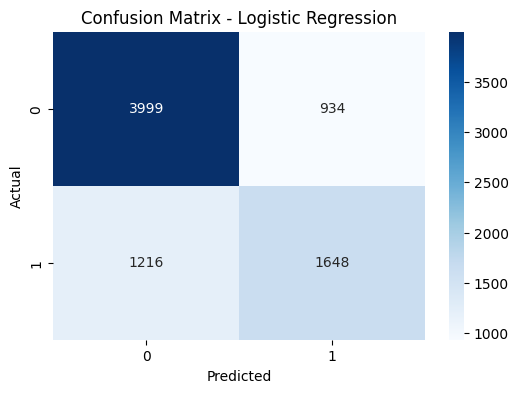

[[3999  934]
 [1216 1648]]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

print(cm)


In [ ]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=["smoking"])
y = train["smoking"]

# Outlier cap again on full X (same logic as your logistic pipeline)
X_capped = X.copy()
X_capped[numeric_cols] = cap_outliers(X, numeric_cols)

X_train2, X_valid, y_train2, y_valid = train_test_split(
    X_capped, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# numeric & categorical transformers reused
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=3000))
])


In [ ]:
param_grid = {
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__penalty": ["l1", "l2"],
    "model__solver": ["liblinear", "saga"]
}


In [ ]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train2, y_train2)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'height(cm)',
                                                                          'weight(kg)',
                                                                          'waist(cm)',
                                                                          'eyesight(left)',
                                                                          'eyesight(right)',
                                                                          'hearing(left)',
                                                                          'hearing(right)',
                                                                          'systolic',
                                                                          'relaxation',
                                                                          'fasting '
                                                                          'blood '
                                                                          'sugar',
                                                                          '...
                                                                          'ALT',
                                                                          'Gtp',
                                                                          'dental '
                                                                          'caries']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [])])),
                                       ('model',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['liblinear', 'saga']},
             scoring='roc_auc')

In [ ]:
print("Best Parameters:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)


Best Parameters: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best CV AUC: 0.8152863921026808


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_pred = grid.predict(X_valid)
y_prob = grid.predict_proba(X_valid)[:,1]

print("Validation Accuracy:", accuracy_score(y_valid, y_pred))
print("Validation F1:", f1_score(y_valid, y_pred))
print("Validation AUC:", roc_auc_score(y_valid, y_prob))


Validation Accuracy: 0.7243811722457355
Validation F1: 0.605325987144169
Validation AUC: 0.8067223702643354


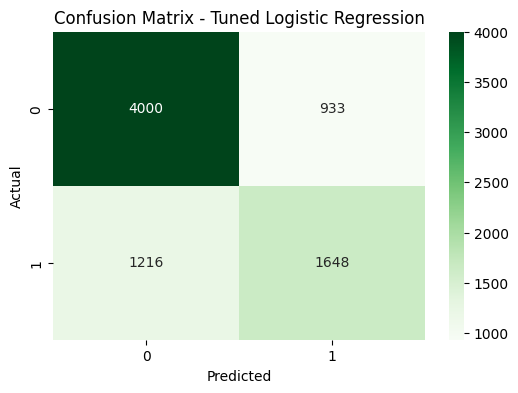

[[4000  933]
 [1216 1648]]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_valid, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.show()

print(cm)
